In [1]:
import pandas as pd
import funciones

In [2]:
# Leer los tres dataframes procesados desde la carpeta 'df_procesados'
df_planta_1 = pd.read_csv('df_procesados/df_planta_1.csv')
df_planta_2 = pd.read_csv('df_procesados/df_planta_2.csv')
df_planta_3 = pd.read_csv('df_procesados/df_planta_3.csv')

# New

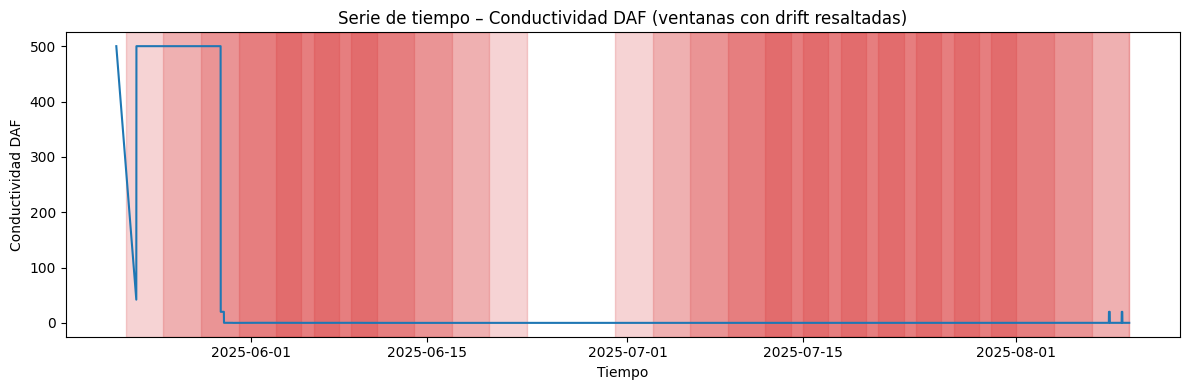

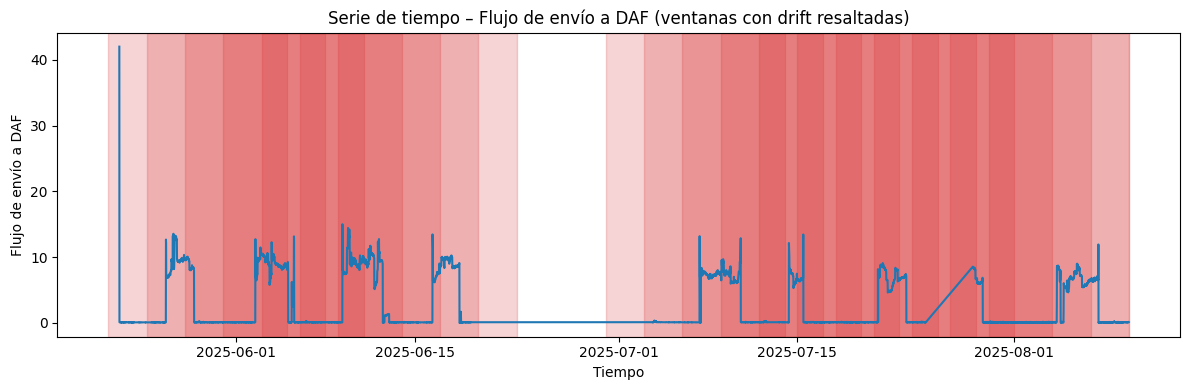

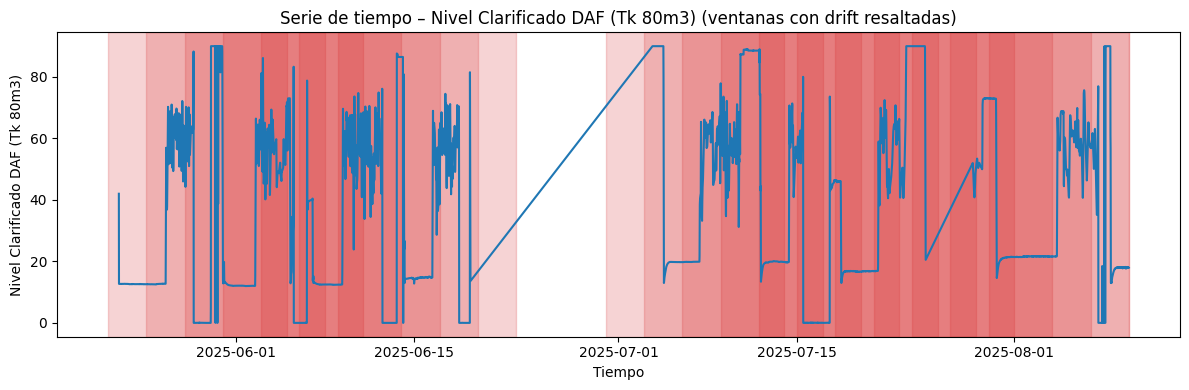

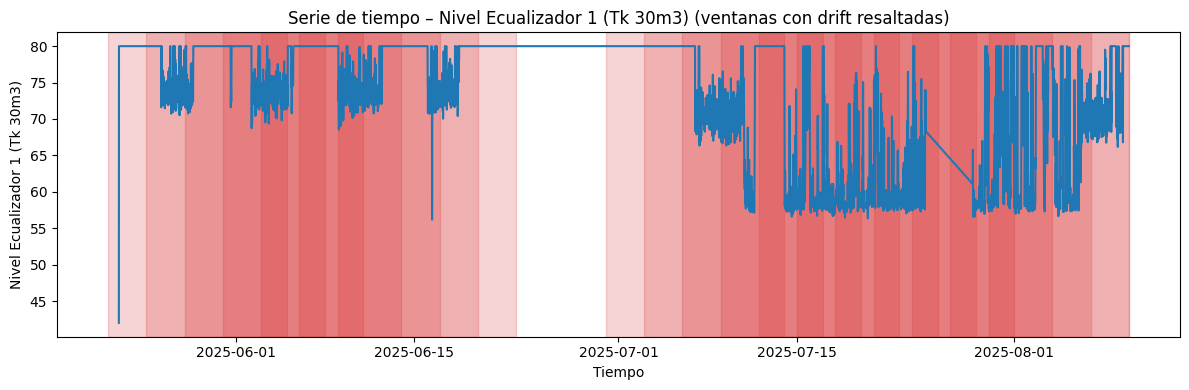

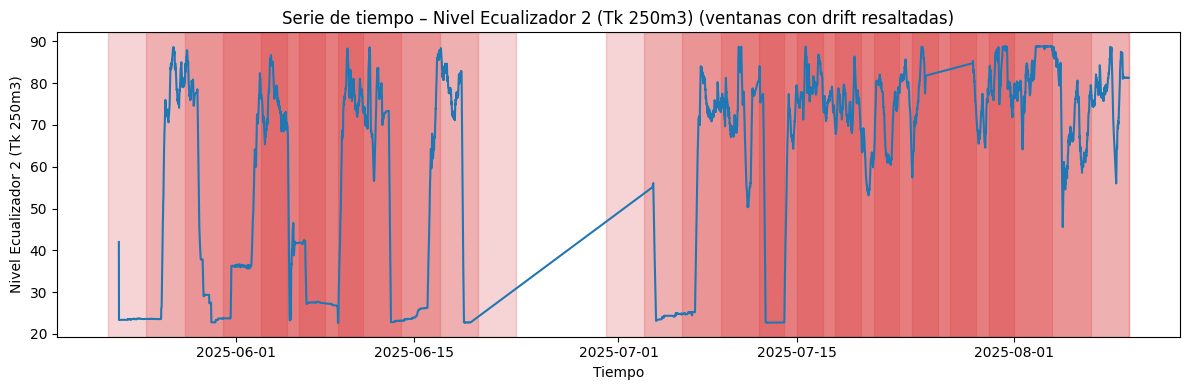

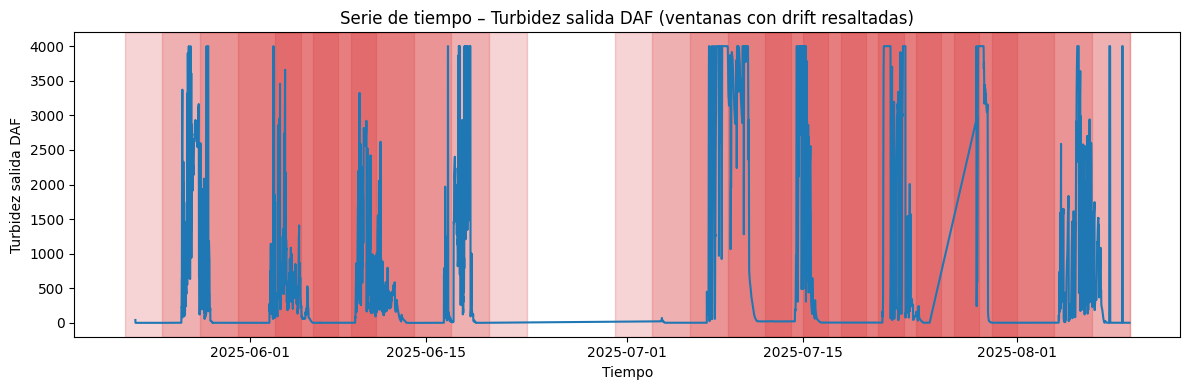

In [3]:
import drift_tools as dt
import pandas as pd

df = df_planta_1.copy()
FECHA = "date_time"

# === 1) KS para TODAS las columnas numéricas ===
# (si dejas cols=None, ks_sliding_windows toma todas las numéricas automáticamente)
res = dt.ks_sliding_windows(
    df, fecha_col=FECHA, cols=None,
    window_days=14, step_days=3,
    min_days_coverage=10, min_points=5000,
    compare="baseline", alpha=0.01
)

# === 2) Endurecer por variable (FDR + KS mínimo + persistencia) y combinar ===
res_plot_all = res.copy()

# guardamos res_hard y blocks por si quieres inspeccionarlos/guardar
hard_by_var = {}
blocks_by_var = {}

for var in res["variable"].dropna().unique():
    res_hard, blocks = dt.harden_ks_results(
        res, variable=var,
        alpha=0.01, ks_min=0.10, min_consecutive=2
    )
    hard_by_var[var] = res_hard
    blocks_by_var[var] = blocks

    # sobrescribe drift_detectado solo en filas de esa variable (detalle == "ok")
    mask = (res_plot_all["variable"] == var) & (res_plot_all["detalle"] == "ok")
    res_plot_all.loc[mask, "drift_detectado"] = res_hard["drift_hard"].values

# === 3) Resúmenes compactos por variable ===
summaries = {
    var: dt.summarize_drift_windows(res_plot_all, var)
    for var in res_plot_all["variable"].dropna().unique()
}

# Ejemplo: ver el resumen de una variable
# summaries["Flujo Parshall 01 entrada a Ecualizador 1"].head()

# === 4) (Opcional) Graficar solo las TOP-N con más ventanas con drift ===
N_TOP = 6  # cambia este número si quieres más/menos gráficos
counts = (
    res_plot_all[(res_plot_all["detalle"] == "ok") & (res_plot_all["drift_detectado"] == True)]
    .groupby("variable", as_index=False)
    .size()
    .sort_values("size", ascending=False)
)

top_vars = counts["variable"].head(N_TOP).tolist()

for var in top_vars:
    dt.plot_timeseries_with_drift(df, FECHA, var, res_plot_all)

# Si quieres graficarlas TODAS (cuidado con el volumen), reemplaza el loop por:
# for var in res_plot_all["variable"].dropna().unique():
#     dt.plot_timeseries_with_drift(df, FECHA, var, res_plot_all)

# === 5) Resultado combinado listo para exportar/guardar ===
# res_plot_all tiene el drift ya "endurecido" en la columna drift_detectado
# por cada variable y ventana.
# res_plot_all.to_csv("drift_resultados_all.csv", index=False)
